In [1]:
import pandas as pd
import numpy as np

from datetime import datetime

import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')

from scipy import stats

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import warnings
warnings.filterwarnings('ignore')

import itertools

In [2]:
coins_list=[
    'bitcoin', # Bitcoin
    'ethereum', # Ethereum
    'zcash', # Zcash
    'bittorrent', # BitTorrent
    'huobi-token', # Huobi Token
    'pancakeswap', # PancakeSwap
    'thorchain', # THORChain
    'kusama', # Kusama
    '1inch', # 1INCH
    'compound', # Compound
    'dash', # Dash
    'neo', # Neo
    'decred', # Decred
    'bitcoin-gold', # BitcoinGold
]

In [3]:
hmap_coins_data = {}
mcap_df = pd.DataFrame({})
vol_df = pd.DataFrame({})
for coin in coins_list:
    hmap_coins_data[coin] = pd.read_csv(f'data/{coin}.csv') #, index_col = 0)
    hmap_coins_data[coin] = hmap_coins_data[coin].iloc[::-1]
    mcap_df[coin] = hmap_coins_data[coin]['Market Cap']
    vol_df[coin] = hmap_coins_data[coin]['Volume']
    
print(hmap_coins_data.keys())
#print(hmap_coins_data.values())
hmap_coins_data['bitcoin'].columns

dict_keys(['bitcoin', 'ethereum', 'zcash', 'bittorrent', 'huobi-token', 'pancakeswap', 'thorchain', 'kusama', '1inch', 'compound', 'dash', 'neo', 'decred', 'bitcoin-gold'])


Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap'], dtype='object')

In [4]:
################### Manual SARIMA[X] #######################

In [5]:
# Enter crypto name from above list to get predictions
df = hmap_coins_data['bitcoin']
# df = hmap_coins_data['zcash']
# df = hmap_coins_data['ethereum']


In [6]:
df.Date = pd.to_datetime(df.Date)
df.index = df.Date
df = df.resample('D').mean()
df_month = df.resample('M').mean()

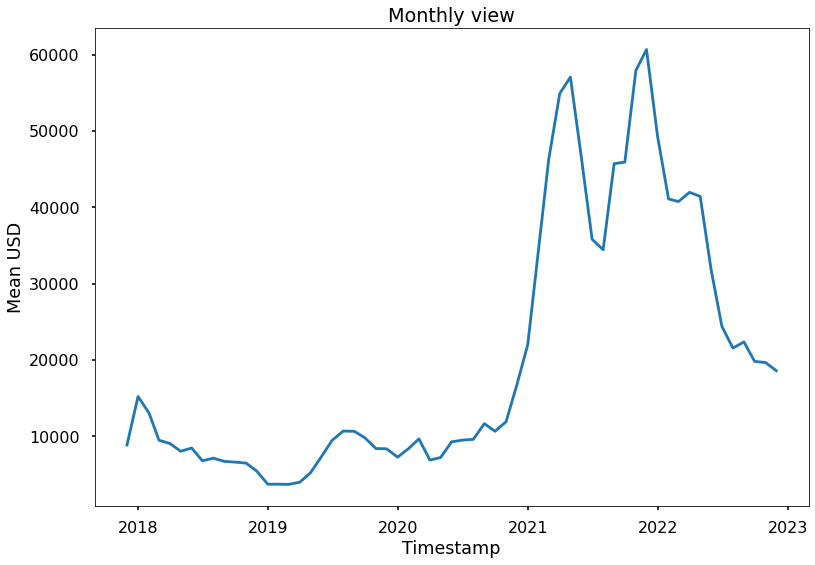

In [7]:
plt.title("Monthly view")
plt.plot(df_month.Close)
plt.xlabel("Timestamp")
plt.ylabel("Mean USD")
plt.show()

In [8]:
# Box Cox, Seasonal, Regular, Seasonal Trend Differentiation
df_month['Close_box'], lmbda = stats.boxcox(df_month.Close)
df_boxcox_transf_Close = df_month.Close_box
df_month['Diff'] = df_boxcox_transf_Close - df_boxcox_transf_Close.shift(12)
print("Augmented Dickey Fuller Test results: p=", sm.tsa.stattools.adfuller(df_month.Diff[12:])[1].round(6))

Augmented Dickey Fuller Test results: p= 0.039023


Augmented Dickey Fuller Test results: p= 8e-06


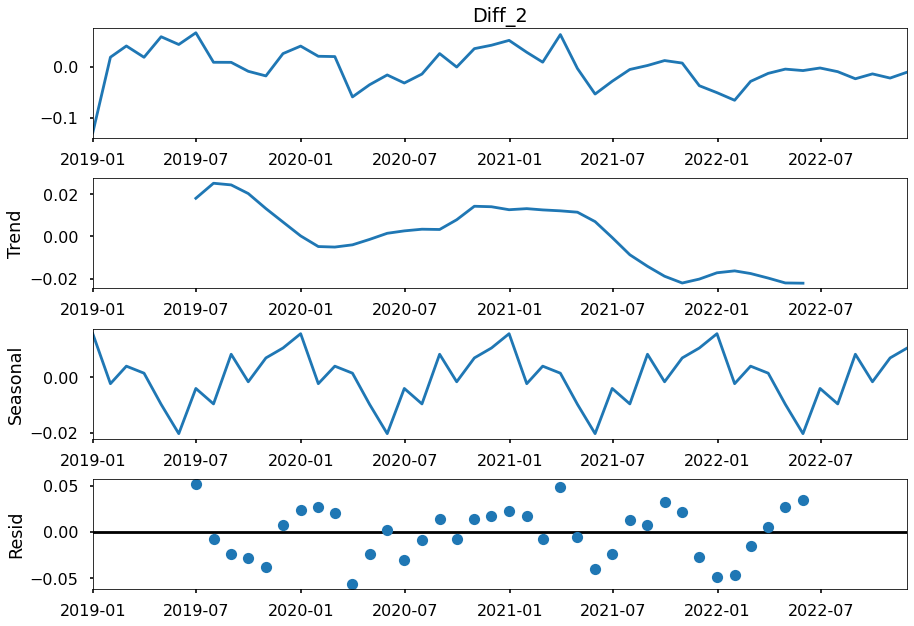

In [9]:
df_month['Diff_2'] = df_month.Diff - df_month.Diff.shift(1)
sm.tsa.seasonal_decompose(df_month.Diff_2[13:]).plot()
print("Augmented Dickey Fuller Test results: p=", sm.tsa.stattools.adfuller(df_month.Diff_2[13:])[1].round(6))
plt.show()

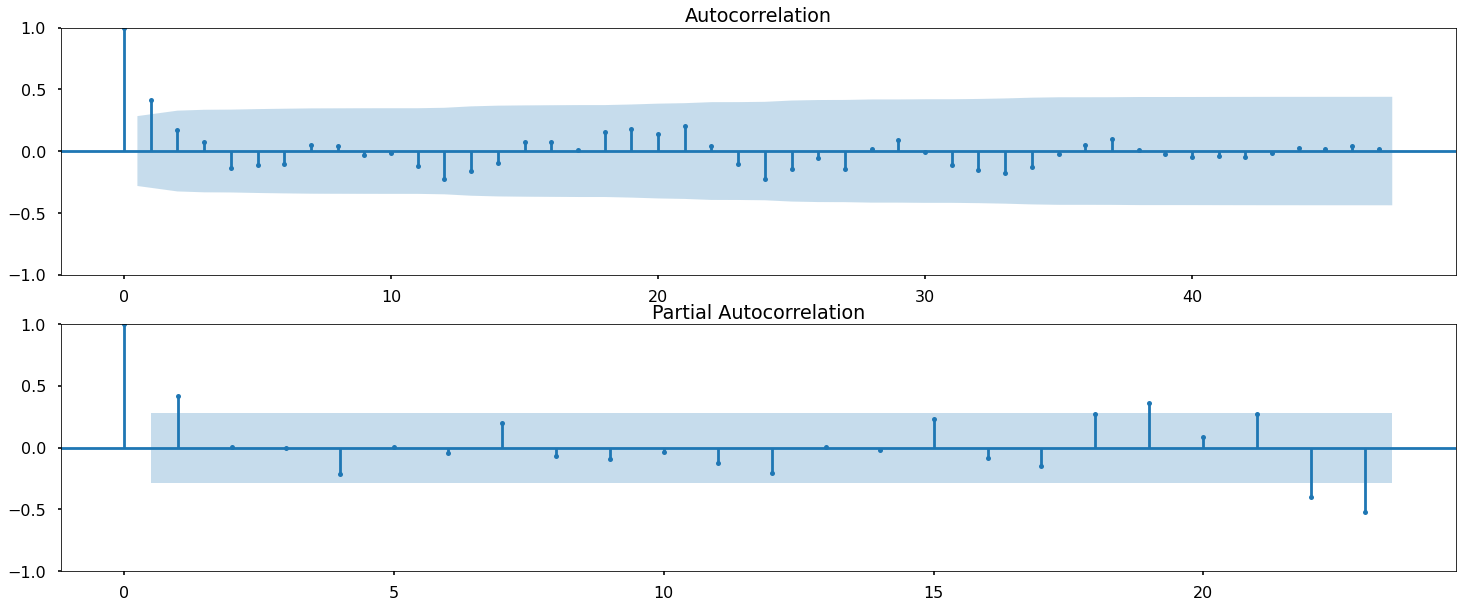

In [10]:
# Determining q and p values using autocorrelation and partial-autocorrelation plots
plt.figure(figsize=(25,10))
plot_acf(df_month.Diff_2[13:].values.squeeze(), lags=47, ax=plt.subplot(211))
plot_pacf(df_month.Diff_2[13:].values.squeeze(), lags=23, ax=plt.subplot(212))
plt.show()

In [11]:
# SARIMA Model = (p, d, q) x (Ps, Ds, Qs)
model_results = []

Qs = range(0, 2)
q = range(0, 3)
Ps = range(0, 3)
p = range(0, 3)

m = 12

possible_parameters = itertools.product(p, q, Ps, Qs)
parameters_list = list(possible_parameters)

best_model_aic = float("inf")
for param in parameters_list: # each param is 1 x 4
    try:
        model=sm.tsa.statespace.SARIMAX(df_boxcox_transf_Close, order=(param[0], 1, param[1]), seasonal_order=(param[2], 1, param[3], m)).fit(disp=-1)
    except ValueError: # Ignore incorrect params from possible_parameters
        print('Model cannot fit for :', param)
        continue

    # Selecting best model using Akaike's Information Criterion
    temp_aic = model.aic
    if temp_aic < best_model_aic:
        best_model = model
        best_model_aic = temp_aic
        best_param = param

    model_results.append([param, model.aic])

In [12]:
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                          Close_box   No. Observations:                   61
Model:             SARIMAX(1, 1, 0)x(2, 1, 0, 12)   Log Likelihood                 102.596
Date:                            Sat, 03 Dec 2022   AIC                           -197.192
Time:                                    20:39:53   BIC                           -189.707
Sample:                                11-30-2017   HQIC                          -194.364
                                     - 11-30-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4797      0.077      6.244      0.000       0.329       0.630
ar.S.L12      -0.4682      0.221   

<AxesSubplot:xlabel='Date'>

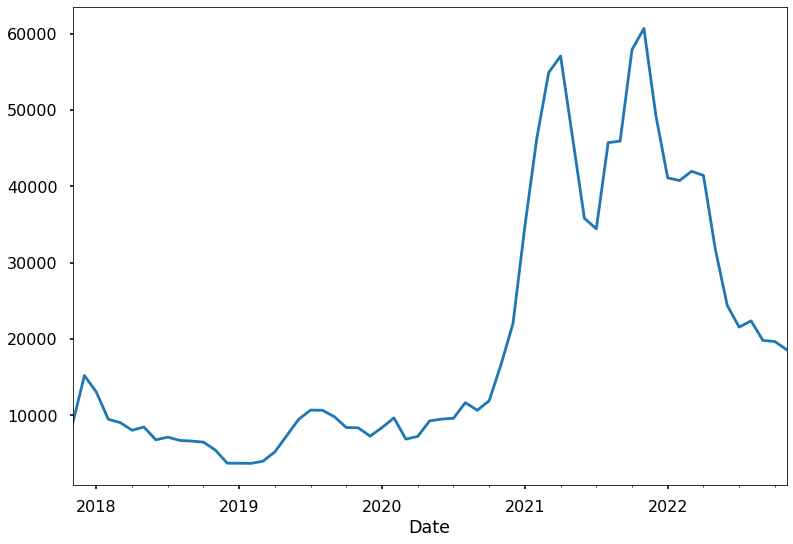

In [13]:
df_month.Close.plot()

In [14]:
def invboxcox(y,lmbda):
    return (np.exp(np.log(lmbda*y+1)/lmbda)) if lmbda else np.exp(y)

In [15]:
forecast_df = df_month[['Close']]
date_list = [datetime(2022, 11, 30), datetime(2022, 12, 31), datetime(2023, 1, 31), datetime(2023, 2, 28), 
             datetime(2023, 3, 31), datetime(2023, 4, 30), datetime(2023, 5, 31), datetime(2023, 6, 30),
             datetime(2023, 7, 31), datetime(2023, 8, 31), datetime(2023, 9, 30), datetime(2023, 10, 31),
            datetime(2023, 11, 30), datetime(2023, 12, 31), datetime(2024, 1, 31), datetime(2024, 2, 28),
             datetime(2024, 3, 31),  datetime(2024, 4, 30),  datetime(2024, 5, 31),  datetime(2024, 6, 30)]
forecast_frame = pd.DataFrame(index = date_list, columns = df_month.columns)
forecast_df = pd.concat([forecast_df, forecast_frame])
forecast_df['forecast'] = invboxcox(best_model.predict(start=0, end=89), lmbda)

# Filling NA values for smooth curve
forecast_df['forecast'].fillna(method='ffill', inplace=True)

<AxesSubplot:>

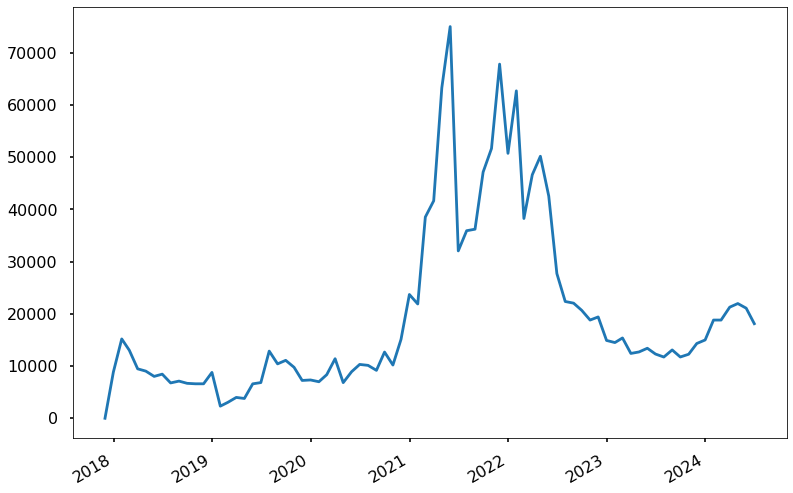

In [16]:
forecast_df.forecast.plot()

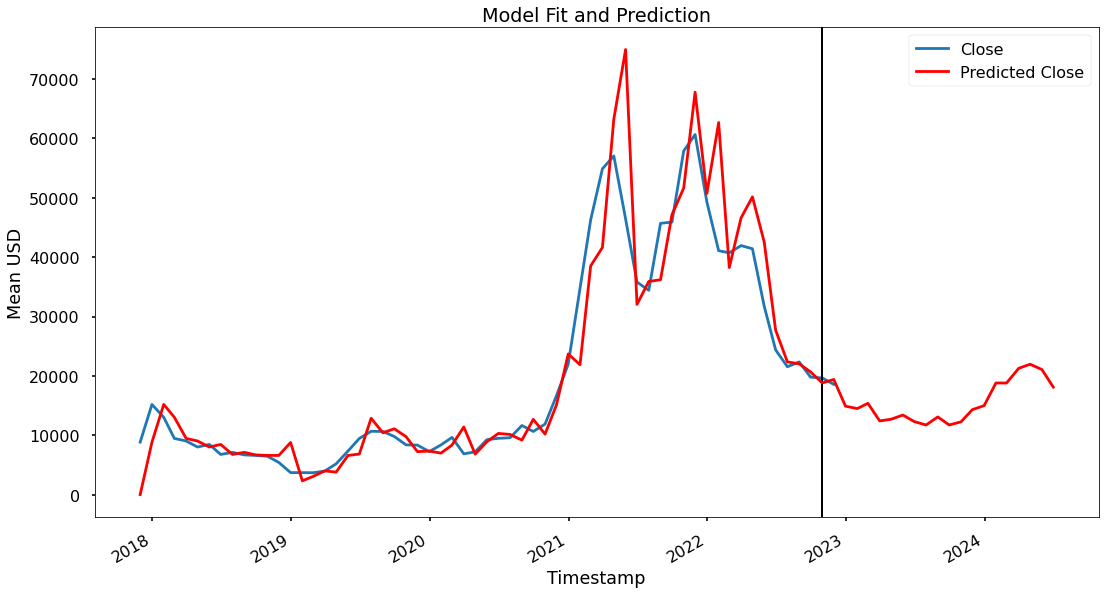

In [17]:
plt.figure(figsize=(18,10))
forecast_df.Close.plot().axvline(x = datetime(2022, 10, 31), color = "black", lw = 2)
forecast_df.forecast.plot(color='r', label='Predicted Close')
plt.legend()
plt.title('Model Fit and Prediction')
plt.xlabel('Timestamp')
plt.ylabel('Mean USD')
plt.show()

In [18]:
forecast_df.columns

Index(['Close', 'Open', 'High', 'Low', 'Volume', 'Market Cap', 'Close_box',
       'Diff', 'Diff_2', 'forecast'],
      dtype='object')

In [19]:
forecast_df["forecast_shift"] = forecast_df.forecast.shift(1)
forecast_df.forecast_shift

2017-11-30             NaN
2017-12-31        1.000000
2018-01-31     8842.844764
2018-02-28    15191.029660
2018-03-31    13027.788760
                  ...     
2024-02-28    18804.590344
2024-03-31    18804.590344
2024-04-30    21274.716656
2024-05-31    21964.167093
2024-06-30    21077.284125
Name: forecast_shift, Length: 81, dtype: float64

In [20]:
forecast_df["trade_call"] = np.where(forecast_df.forecast_shift > forecast_df.forecast, 1, -1)
forecast_df.trade_call

2017-11-30   -1
2017-12-31   -1
2018-01-31   -1
2018-02-28    1
2018-03-31    1
             ..
2024-02-28   -1
2024-03-31   -1
2024-04-30   -1
2024-05-31    1
2024-06-30    1
Name: trade_call, Length: 81, dtype: int64

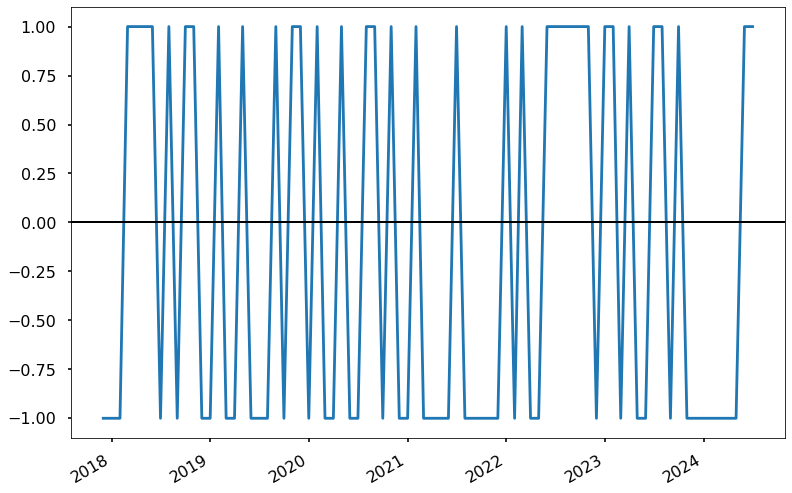

In [21]:
forecast_df.trade_call.plot().axhline(y = 0, color = "black", lw = 2)

In [22]:
forecast_df.to_csv('data/bitcoin_arima_forecasts.csv')